In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn import preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [52]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming_noDrops.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [53]:
train_limpio["text"] = train_limpio["text"].map(lambda x : "null" if(x is None) else x)
test_limpio["text"] = test_limpio["text"].map(lambda x : "null" if(x is None) else x)

In [54]:
train_limpio_true = train_limpio.loc[train_limpio["target"] == 1]
train_limpio_false = train_limpio.loc[train_limpio["target"] == 0]

In [55]:
print("Tenemos {cant_verdaderos: .2f} verdaderos y {cant_falsos: .2f} falsos".format(cant_verdaderos=len(train_limpio_true), cant_falsos=len(train_limpio_false)))

Tenemos  3271.00 verdaderos y  4342.00 falsos


## Voy a balancear el train y el validation, misma cantidad de falsos y verdaderos en ambos

In [56]:
train = pd.concat([train_limpio_true.iloc[:2616], train_limpio_false.iloc[:3473]])
val = pd.concat([train_limpio_true.iloc[2616:3000], train_limpio_false.iloc[3473:3850]])
test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[3850:]])

In [57]:
train.head(2)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas,sentimiento,objetividad,keyword,location
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,90,2,0.0,1.0,catastroph,NaN
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,60,2,0.0,1.0,mass%20murder,"West\ Hollywood\,\ CA"


In [58]:
vectorizer = CountVectorizer()
vectorizer.fit(train_limpio["text"].values.astype('U'))

X_train = vectorizer.transform(train["text"].values.astype('U'))
X_val  = vectorizer.transform(val["text"].values.astype('U'))
X_test = vectorizer.transform(test["text"].values.astype('U'))

actual_tp_test_only_text = vectorizer.transform(test_limpio["text"].values.astype('U'))

In [59]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Primer modelo simple

In [60]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                133800    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 133,811
Trainable params: 133,811
Non-trainable params: 0
_________________________________________________________________


In [61]:
first_history = model.fit(X_train, train["target"].to_numpy(),
                    epochs=100,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

Epoch 1/100
609/609 [==============================] - 1s 1ms/step - loss: 0.5368 - acc: 0.7640 - val_loss: 0.4729 - val_acc: 0.7963
Epoch 2/100
609/609 [==============================] - 1s 1ms/step - loss: 0.3354 - acc: 0.8747 - val_loss: 0.4698 - val_acc: 0.8108
Epoch 3/100
609/609 [==============================] - 1s 1ms/step - loss: 0.2289 - acc: 0.9182 - val_loss: 0.4929 - val_acc: 0.8016
Epoch 4/100
609/609 [==============================] - 1s 2ms/step - loss: 0.1653 - acc: 0.9414 - val_loss: 0.5418 - val_acc: 0.7806
Epoch 5/100
609/609 [==============================] - 1s 1ms/step - loss: 0.1247 - acc: 0.9596 - val_loss: 0.6034 - val_acc: 0.7766
Epoch 6/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0996 - acc: 0.9665 - val_loss: 0.6402 - val_acc: 0.7766
Epoch 7/100
609/609 [==============================] - 1s 1ms/step - loss: 0.0820 - acc: 0.9713 - val_loss: 0.6999 - val_acc: 0.7766
Epoch 8/100
609/609 [==============================] - 1s 1ms/step - 

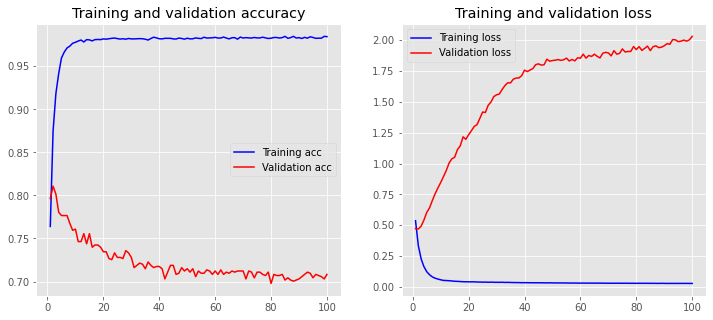

In [62]:
plot_history(first_history)

In [63]:
loss, accuracy = model.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7025


In [64]:
firstPredictions = list(map(lambda x: x[0], model.predict_classes(actual_tp_test_only_text)))

In [65]:
firstPredictionsDF = pd.DataFrame(data={'id': test_limpio["id"], 'target': firstPredictions})
firstPredictionsDF.head(10)

,id,target
0,2626,0
1,1359,0
2,3541,1
3,5718,1
4,6531,1
5,6887,0
6,10190,0
7,8876,0
8,2652,1
9,6713,0


In [66]:
firstPredictionsDF.to_csv('NN_predictions_first_model.csv', index=False)

## Segundo modelo, agrego ciudades y Tokenizer en vez de count para las words

In [67]:
non_null_locations = train_limpio[train_limpio.location.notnull()]["location"].to_numpy()
non_null_locations

array(['Washington', 'Roppongi\\,\\ Minato\\,\\ Tokyo\\ ',
       'West\\ Hollywood\\,\\ CA', ..., 'South Africa', 'Heathrow',
       'The\\ green\\ and\\ pleasant\\ land\\.'], dtype=object)

In [68]:
encoder = LabelEncoder()
locations = encoder.fit_transform(non_null_locations)
len(locations)

5080

In [69]:
encoder = OneHotEncoder(sparse=False)
locations = locations.reshape((5080, 1))
encoder.fit_transform(locations)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [70]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_limpio["text"].values.astype('U'))

X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
X_val = tokenizer.texts_to_sequences(val["text"].values.astype('U'))
X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train_limpio["text"].values[2])
print(X_train[2])

pxnatosil renunciedilma fatal
[124, 59, 8, 41, 585, 14, 96, 586, 5, 156, 259, 462, 30, 3009, 3011, 318, 2190, 242]


In [71]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Pruebo solo texto, modelo mas complejo con maxPooling y mejor embedding

In [72]:
embedding_dim = 50

model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           675500    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 676,021
Trainable params: 676,021
Non-trainable params: 0
_________________________________________________________________


Testing Accuracy:  0.7261


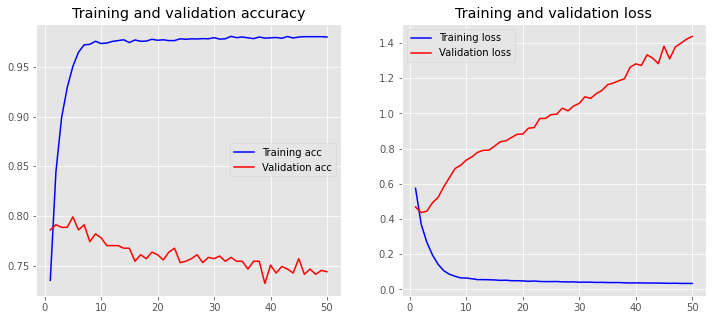

In [73]:
second_history = model1.fit(X_train, train["target"].to_numpy(),
                    epochs=50,
                    verbose=False,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)

loss, accuracy = model1.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(second_history)

## Tercer modelo

In [74]:
embedding_dim = 100

model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1351000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,416,429
Trainable params: 1,416,429
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 8s 14ms/step - loss: 0.5251 - acc: 0.7385 - val_loss: 0.4647 - val_acc: 0.7819
Epoch 2/10
609/609 [==============================] - 8s 13ms/step - loss: 0.3263 - acc: 0.8711 - val_loss: 0.4852 - val_acc: 0.7806
Epoch 3/10
609/609 [==============================] - 8s 12ms/step - loss: 0.2031 - acc: 0.9256 - val_loss: 0.6430 - val_acc: 0.7753
Epoch 4/10
609/609 [==============================] - 8s 14ms/step - loss: 0.1238 - acc: 0.9566 - val_loss: 0.7375 - val_acc: 0.7700
Epoch 5/10
609/609 [==============================] - 8s 12ms/step - loss: 0.0897 - acc: 0.9722 - val_loss: 0.7805 - val_acc: 0.7516
Epoch 6/10
609/609 [==============================] - 8s 13ms/step - loss: 0.0768 - acc: 0.9744 - val_loss: 0.7622 - val_acc: 0.7451
Epoch 7/10
609/609 [==============================] - 8s 12ms/step - loss: 0.0698 - acc: 0.9734 - val_loss: 0.8874 - val_acc: 0.7661
Epoch 8/10
609/609 [==============================] - 8s 13ms/step - 

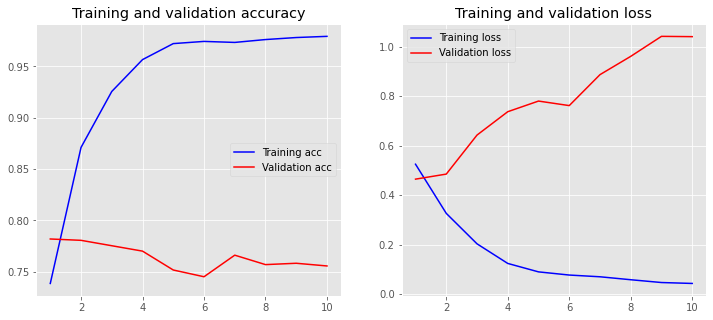

In [75]:
third_history = model2.fit(X_train, train["target"].to_numpy(),
                    epochs=10,
                    verbose=True,
                    validation_data=(X_val, val["target"].to_numpy()),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, train["target"].to_numpy(), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, test["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(third_history)


## Cuarto Modelo

In [76]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model3 = Sequential()
    model3.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model3.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(10, activation='relu'))
    model3.add(layers.Dense(1, activation='sigmoid'))
    model3.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model3

param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [77]:
# # Main settings
# epochs = 20
# embedding_dim = 50
# maxlen = 100
# output_file = 'output.txt'

# source = "twitter"
# # Run grid search for each source (yelp, amazon, imdb)
# print('Running grid search for data set :', "twitter")
# sentences = train_limpio["text"].values.astype('U')
# # Train-test split
# train = pd.concat([train_limpio_true.iloc[:3000], train_limpio_false.iloc[:4000]]).sample(frac=1).reset_index(drop=True)
# test = pd.concat([train_limpio_true.iloc[3000:], train_limpio_false.iloc[4000:]]).sample(frac=1).reset_index(drop=True)

# # Tokenize words
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(sentences)
# X_train = tokenizer.texts_to_sequences(train["text"].values.astype('U'))
# X_test = tokenizer.texts_to_sequences(test["text"].values.astype('U'))

# # Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# # Pad sequences with zeros
# X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
# X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# # Parameter grid for grid search
# param_grid = dict(num_filters=[32, 64, 128],
#                       kernel_size=[3, 5, 7],
#                       vocab_size=[vocab_size],
#                       embedding_dim=[embedding_dim],
#                       maxlen=[maxlen])
# model3 = KerasClassifier(build_fn=create_model,
#                         epochs=epochs, batch_size=10,
#                             verbose=False)
# grid = RandomizedSearchCV(estimator=model3, param_distributions=param_grid,
#                               cv=10, verbose=1, n_iter=10)
# grid_result = grid.fit(X_train, train["target"])

# # Evaluate testing set
# test_accuracy = grid.score(X_test, test["target"])

# # Save and evaluate results
# #     prompt = input(f'finished {source}; write to file and proceed? [y/n]')
# #     if prompt.lower() not in {'y', 'true', 'yes'}:
# #         break
# #     with open(output_file, 'w+') as f:
# s = ('Running {} data set\nBest Accuracy : '
#              '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
# output_string = s.format(
#         source,
#         grid_result.best_score_,
#         grid_result.best_params_,
#         test_accuracy)
# print(output_string)
# #         f.write(output_string)

# Modelo con tf idf

In [78]:
train_limpio_tf_idf = pd.read_csv("train_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)
test_limpio_tf_idf = pd.read_csv("test_limpio_con_Tf-Idf.csv",encoding = "ISO-8859-1").sample(frac=1).reset_index(drop=True)

In [79]:
train_limpio_tf_idf = train_limpio_tf_idf.drop(columns=["id"])

In [80]:
train_limpio_tf_idf_true = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 1]
train_limpio_tf_idf_false = train_limpio_tf_idf.loc[train_limpio_tf_idf["target"] == 0]

In [81]:
train_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[:2616], train_limpio_tf_idf_false.iloc[:3473]])
val_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[2616:3000], train_limpio_tf_idf_false.iloc[3473:3850]])
test_tf_idf = pd.concat([train_limpio_tf_idf_true.iloc[3000:], train_limpio_tf_idf_false.iloc[3850:]])

In [82]:
x_train_tf_idf = train_tf_idf.iloc[:, :2392]
x_val_tf_idf = val_tf_idf.iloc[:, :2392]
x_test_tf_idf = test_tf_idf.iloc[:, :2392]

In [83]:
input_dim_tf_idf = x_train_tf_idf.shape[1]  # Number of features

modelTfIdf = Sequential()
modelTfIdf.add(layers.Dense(10, input_dim=input_dim_tf_idf, activation='relu'))
modelTfIdf.add(layers.Dense(1, activation='sigmoid'))

modelTfIdf.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelTfIdf.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                23930     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 23,941
Trainable params: 23,941
Non-trainable params: 0
_________________________________________________________________


In [84]:
first_history_tf_idf = modelTfIdf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
                    epochs=22,
                    verbose=True,
                    validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
                    batch_size=10)

Epoch 1/22
609/609 [==============================] - 1s 1ms/step - loss: 0.6070 - acc: 0.7039 - val_loss: 0.5437 - val_acc: 0.7424
Epoch 2/22
609/609 [==============================] - 1s 1ms/step - loss: 0.4333 - acc: 0.8312 - val_loss: 0.4978 - val_acc: 0.7556
Epoch 3/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3639 - acc: 0.8520 - val_loss: 0.4785 - val_acc: 0.7661
Epoch 4/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3291 - acc: 0.8657 - val_loss: 0.5068 - val_acc: 0.7687
Epoch 5/22
609/609 [==============================] - 1s 1ms/step - loss: 0.3048 - acc: 0.8772 - val_loss: 0.5257 - val_acc: 0.7700
Epoch 6/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2869 - acc: 0.8836 - val_loss: 0.5376 - val_acc: 0.7674
Epoch 7/22
609/609 [==============================] - 1s 1ms/step - loss: 0.2718 - acc: 0.8898 - val_loss: 0.5523 - val_acc: 0.7674
Epoch 8/22
609/609 [==============================] - 1s 1ms/step - loss: 0.

In [85]:
loss, accuracy = modelTfIdf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7798


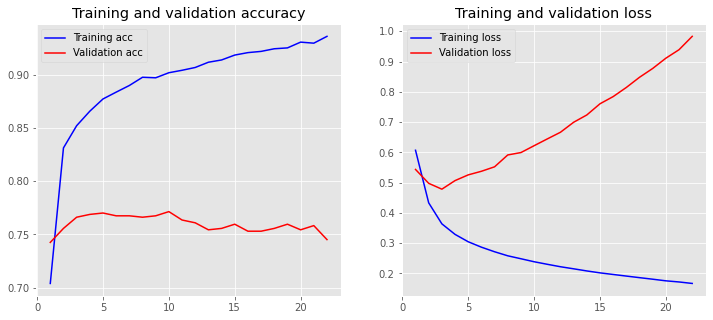

In [86]:
plot_history(first_history_tf_idf)

## Segundo modelo, con conv1D y maxPooling (anda muy mal)

In [87]:
# embedding_dim = 100
# model2_tf_idf = Sequential()
# model2_tf_idf.add(layers.Embedding(2400, embedding_dim, input_length=2392))
# model2_tf_idf.add(layers.Conv1D(128, 5, activation='relu'))
# model2_tf_idf.add(layers.GlobalMaxPooling1D())
# model2_tf_idf.add(layers.Dense(10, activation='relu'))
# model2_tf_idf.add(layers.Dense(1, activation='sigmoid'))
# model2_tf_idf.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['acc'])
# model2_tf_idf.summary()

In [88]:
# second_history_tf_idf = model2_tf_idf.fit(x_train_tf_idf.values, train_tf_idf["target"].to_numpy(),
#                     epochs=3,
#                     verbose=True,
#                     validation_data=(x_val_tf_idf.values, val_tf_idf["target"].to_numpy()),
#                     batch_size=10)

In [89]:
# loss, accuracy = model2_tf_idf.evaluate(x_test_tf_idf.values, test_tf_idf["target"].to_numpy(), verbose=False)
# print("Testing Accuracy:  {:.4f}".format(accuracy))

## Modelo con más features, usando set de datos comun

In [144]:
test_limpio = pd.read_csv("test_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
test_limpio = test_limpio.drop(columns=["sentimiento", "objetividad"])
test_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,40,2


In [145]:
train_limpio = pd.read_csv("train_limpio_con_BOW_de_5000_y_Stemming.csv",encoding = "ISO-8859-1")
train_limpio = train_limpio.drop(columns=["sentimiento", "objetividad", "id"])
train_limpio.head(1)

,aa,ab,aba,abandon,abbott,abbswinston,abc,abcnew,abe,abil,...,www\.twitch\.tv\/PKSparkxx-location,www\.youtube\.com\?Malkavius2-location,xiumin\'s\ nonexistent\ solos-location,y\(our\)\ boyfriends\ legs\ -location,y\/e\/l-location,yorkshire\\n-location,youtube\.com\/channel\/UCHWTLC9B4ZjUGh7yDlb55Iw-location,zboyer\@washingtontimes\.com-location,longitud_tweet,letras_seguidas
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,70,2


In [146]:
train_limpio_more_features_true = train_limpio.loc[train_limpio["target"] == 1].sample(frac=1).reset_index(drop=True)
train_limpio_more_features_false = train_limpio.loc[train_limpio["target"] == 0].sample(frac=1).reset_index(drop=True)

In [147]:
train_more_feature = pd.concat([train_limpio_more_features_true.iloc[:2616], train_limpio_more_features_false.iloc[:3473]])
val_more_feature = pd.concat([train_limpio_more_features_true.iloc[2616:3000], train_limpio_more_features_false.iloc[3473:3850]])
test_more_feature = pd.concat([train_limpio_more_features_true.iloc[3000:], train_limpio_more_features_false.iloc[3850:]])

train_more_feature_target = train_more_feature.pop("target")
val_more_feature_target = val_more_feature.pop("target")
test_more_feature_target = test_more_feature.pop("target")

In [148]:
actual_test_ids = test_limpio.pop("id")
actual_test_limpio = pd.DataFrame(test_limpio.values)

In [95]:
input_dim = train_more_feature.shape[1]  # Number of features

modelFeatures = Sequential()
modelFeatures.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
modelFeatures.add(layers.Dense(1, activation='sigmoid'))

modelFeatures.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelFeatures.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                78470     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 78,481
Trainable params: 78,481
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
609/609 [==============================] - 1s 1ms/step - loss: 0.6355 - acc: 0.6408 - val_loss: 0.6130 - val_acc: 0.7438
Epoch 2/10
609/609 [==============================] - 1s 1ms/step - loss: 0.5349 - acc: 0.7995 - val_loss: 0.5766 - val_acc: 0.7464
Epoch 3/10
609/609 [==============================] - 1s 1ms/step - loss: 0.4605 - acc: 0.8464 - val_loss: 0.5287 - val_acc: 0.7924
Epoch 4/10
609/609 [==============================] - 1s 1ms/step - loss: 0.4033 - acc: 0.8676 - val_loss: 0.4954 - val_acc: 0.7989
Epoch 5/10
609/609 [==============================] - 1s 1ms/step - loss: 0.3553 - acc: 0.8850 - val_loss: 0.4937 - val_acc: 0.7924
Epoch 6/10
609/609 [==============================] - 1s 1ms/step - loss: 0.3159 - acc: 0.8982 - val_loss: 0.5539 - val_acc: 0.7884
Epoch 7/10
609/609 [==============================] - 1s 1ms/step - loss: 0.2827 - acc: 0.9115 - val_loss: 0.5671 - val_acc: 0.7858
Epoch 8/10
609/609 [==============================] - 1s 1ms/step - loss: 0.

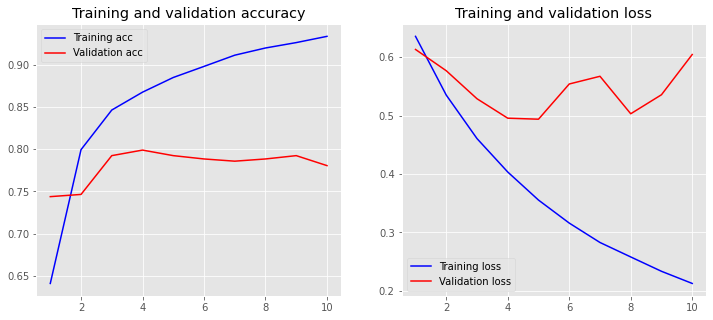

In [96]:
features_history = modelFeatures.fit(train_more_feature.to_numpy(dtype="float32"), train_more_feature_target.to_numpy(dtype="float32"),
                    epochs=10,
                    verbose=True,
                    validation_data=(val_more_feature.to_numpy(dtype="float32"), val_more_feature_target.to_numpy(dtype="float32")),
                    batch_size=10)
loss, accuracy = modelFeatures.evaluate(train_more_feature.to_numpy(dtype="float32"), train_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelFeatures.evaluate(test_more_feature.to_numpy(dtype="float32"), test_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(features_history)

In [97]:
moreFeaturesPredictions = list(map(lambda x: x[0], modelFeatures.predict_classes(actual_test_limpio.to_numpy(dtype="float32"))))

In [98]:
moreFeaturesPredictionsDF = pd.DataFrame(data={'id': actual_test_ids, 'target': moreFeaturesPredictions})
moreFeaturesPredictionsDF.head(10)

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [99]:
moreFeaturesPredictionsDF.to_csv('NN_predictions_more_features.csv', index=False)

In [120]:
train_more_feature_reshaped.shape

(6089, 32, 246)

## Mismos features que arriba pero con modelo más complejo

In [149]:
#Necesito reshape para usar conv
#Voy a padear para tener más dimensiones
def addZeroFilledColumns(dataframe):
    for col in range(26):
        dataframe['{}-{}'.format(col, col)] = 0
    return dataframe

train_more_feature_resized = addZeroFilledColumns(train_more_feature).to_numpy(dtype="float32")
val_more_feature_resized = addZeroFilledColumns(val_more_feature).to_numpy(dtype="float32")
test_more_feature_resized = addZeroFilledColumns(test_more_feature).to_numpy(dtype="float32")
actual_test_limpio_resized = addZeroFilledColumns(actual_test_limpio).to_numpy(dtype="float32")


train_more_feature_reshaped = train_more_feature_resized.reshape(4, train_more_feature.shape[0] // 10, 32, train_more_feature.shape[1] // 32)
val_more_feature_reshaped = val_more_feature_resized.reshape(4, val_more_feature.shape[0] // 10, 32, val_more_feature.shape[1] // 32)
test_more_feature_reshaped = test_more_feature_resized.reshape(4, test_more_feature.shape[0] // 10, 32, test_more_feature.shape[1] // 32)

actual_test_limpio_reshaped = actual_test_limpio_resized.reshape(4, actual_test_limpio.shape[0] // 10, 32, actual_test_limpio.shape[1] // 32)

ValueError: cannot reshape array of size 47932608 into shape (10,608,32,246)

In [133]:
height = train_more_feature_reshaped.shape[1]
width = train_more_feature_reshaped.shape[2]
channel = 1

modelFeaturesWithConv = Sequential()
modelFeaturesWithConv.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 1, width, height), data_format='channels_first'))
modelFeaturesWithConv.add(layers.Dense(10, activation='relu'))
modelFeaturesWithConv.add(layers.Dense(1, activation='sigmoid'))

modelFeaturesWithConv.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])
modelFeaturesWithConv.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 244, 30)       640       
_________________________________________________________________
dense_28 (Dense)             (None, 64, 244, 10)       310       
_________________________________________________________________
dense_29 (Dense)             (None, 64, 244, 1)        11        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [134]:
features_withConv_history = modelFeaturesWithConv.fit(train_more_feature_reshaped, train_more_feature_target.to_numpy(dtype="float32"),
                    epochs=10,
                    verbose=True,
                    validation_data=(val_more_feature_reshaped, val_more_feature_target.to_numpy(dtype="float32")),
                    batch_size=10)
loss, accuracy = modelFeaturesWithConv.evaluate(train_more_feature_reshaped, train_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelFeaturesWithConv.evaluate(test_more_feature_reshaped, test_more_feature_target.to_numpy(dtype="float32"), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(features_withConv_history)

Epoch 1/10


ValueError: in user code:

    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/lucasotero/datos/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_19 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: [None, 32, 246]


In [ ]:
moreFeaturesConvPredictions = list(map(lambda x: x[0][0], modelFeaturesWithConv.predict_classes(actual_test_limpio_reshaped)))

In [ ]:
moreFeaturesPredictionsConvDF = pd.DataFrame(data={'id': actual_test_ids, 'target': moreFeaturesConvPredictions})
moreFeaturesPredictionsConvDF.head(10)

In [ ]:
moreFeaturesPredictionsConvDF.to_csv('NN_predictions_more_features_conv.csv', index=False)